# Training Norm-reference encoding on FERG dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import tensorflow as tf

from utils.load_config import load_config
from utils.load_data import load_data
from utils.extraction_model import load_extraction_model

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=180)

### declare parameters

In [2]:
# define configuration
config_path = 'NR_02_FERG_m0001.json'

# load config
config = load_config(config_path, path='../../configs/norm_reference')

In [3]:
### Load training data
train_data = load_data(config)
print("shape train_data[0]", np.shape(train_data[0]))

100%|██████████| 2000/2000 [00:03<00:00, 657.10it/s]


shape train_data[0] (2000, 224, 224, 3)


In [4]:
def display_image(image, lmks=None, ref_lmks=None, lmk_size=5, pre_processing=None, figure=None):
    img = np.copy(image)

    if pre_processing == 'VGG19':
        # (un-)process image from VGG19 pre-processing
        img = np.array(img + 128) / 256
        img = img[..., ::-1]  # rgb
        img[img > 1] = 1.0

    # compute padding
    lmk_padding = int(lmk_size/2)

    if ref_lmks is not None:
        # add lmk on image
        ref_lmks = np.array(ref_lmks).astype(int)
        for r_lmk in ref_lmks:
            img[r_lmk[1]-lmk_padding:r_lmk[1]+lmk_padding, r_lmk[0]-lmk_padding:r_lmk[0]+lmk_padding] = [0, 1, 0]

    if lmks is not None:
        # add lmk on image
        lmks = np.array(lmks).astype(int)
        for lmk in lmks:
            img[lmk[1]-lmk_padding:lmk[1]+lmk_padding, lmk[0]-lmk_padding:lmk[0]+lmk_padding] = [0, 1, 1]

    if figure is None:
        plt.figure()
        plt.imshow(img)
    else:
        figure.imshow(img)

In [5]:
def display_images(images, lmks=None, ref_lmks=None, n_max_col=7, size_img=4, lmk_size=5, pre_processing=None):
    n_image = len(images)

    # compute n_row and n_column
    n_col = np.min([n_max_col, n_image])
    n_row = int(n_image / n_col)

    # declare figure
    fig, axs = plt.subplots(n_row, n_col)
    fig.set_figheight(n_row*size_img)
    fig.set_figwidth(n_col*size_img)

    lmk_pos = None

    for i in range(n_row):
        for j in range(n_col):
            img_idx = i * n_col + j

            if lmks is not None:
                lmk_pos = lmks[img_idx]

            if n_row == 1 and n_col == 1:
                display_image(images[img_idx], lmks=lmk_pos, ref_lmks=ref_lmks, lmk_size=lmk_size, pre_processing=pre_processing, figure=axs)
            elif n_row == 1:
                display_image(images[img_idx], lmks=lmk_pos, ref_lmks=ref_lmks, lmk_size=lmk_size, pre_processing=pre_processing, figure=axs[img_idx])
            else:
                display_image(images[img_idx], lmks=lmk_pos, ref_lmks=ref_lmks, lmk_size=lmk_size, pre_processing=pre_processing, figure=axs[i, j])

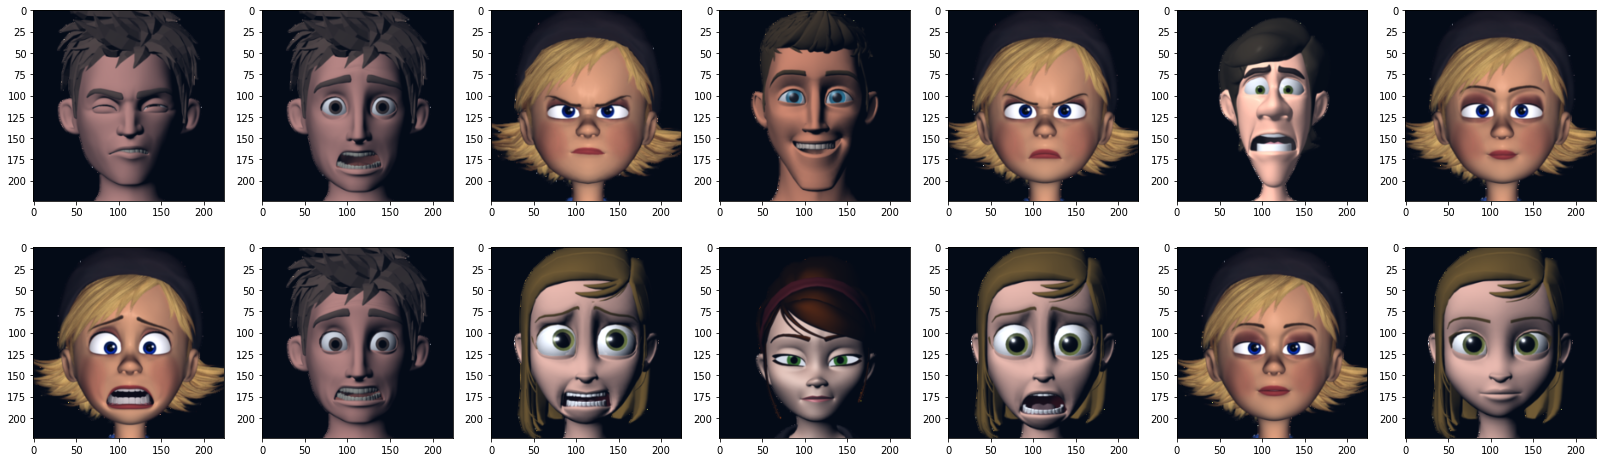

In [6]:
display_images(train_data[0][:14], n_max_col=7, pre_processing='VGG19')

Labeled images

| Avatar  |   Neutral (0) | Happy (1) | Angry (2) |    Sad (3) | Surprise (4) |      Fear (5) |    Disgust (6) |
|:--------|--------------:|----------:|----------:|-----------:|-------------:|--------------:|---------------:|
| Ray     |    21, 37, 49 |   43, 124 |    38, 67 | 15, 22, 47 |      55, 130 |          1, 8 |          0, 26 |
| Bonnie  | 6, 12, 24, 29 |   30, 182 |  2, 4, 44 |   126, 159 |       34, 59 |         7, 16 | 19, 32, 33, 41 |
| Jules   |       20, 163 |     3, 98 |   81, 100 |     17, 35 |       14, 27 |        52, 74 |        80, 114 |
| Malcolm |       77, 135 |    68, 96 |   65, 136 |         39 |          125 |         5, 28 |             90 |
| Aia     |    13, 25, 45 |        50 |        54 |         36 |           48 | 9, 11, 18, 46 |             60 |
| Mery    |        10, 42 |        40 |        23 |         31 |           79 |            91 |            270 |

label: 2


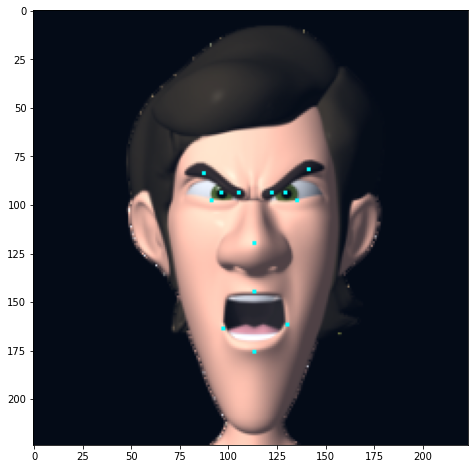

In [93]:
# create labeling
img_idx = 136
print("label:", int(train_data[1][img_idx]))

# l_eye, r_eye, nose, l_eyebrow_ext, l_eyebrow_int, r_eyebrow_int, r_eyebrow_ext,
# l_corner_mouth, up_mouth, r_corner_mouth, lower_mouth,
# l_lower_eyelid, r_lower_eyelid

# [x, y] -> [horizontal, vertical]
lmk_pos = {0: [[[85, 112], [142, 112], [114, 144], [74, 94], [102, 101], [125, 100], [155, 94], [90, 169], [114, 160], [136, 167], [115, 175], [83, 113], [143, 114]]],  # 0 Ray
           1: [[[86, 114], [142, 114], [114, 148], [67, 89], [100, 80], [128, 80], [160, 89], [86, 184], [114, 165], [140, 184], [114, 193], [82, 124], [145, 124]]],  # 1 Ray
           2: [[[91, 117], [137, 117], [114, 142], [70, 101], [100, 112], [130, 112], [160, 101], [95, 167], [114, 161], [131, 167], [114, 170], [83, 128], [145, 128]]],  # 2 Bonnie
           3: [[[88, 103], [139, 103], [114, 139], [74, 74], [99, 75], [128, 75], [154, 74], [85, 154], [114, 154], [145, 151], [114, 174], [84, 110], [142, 110]]],  # 3 Jules
           4: [[[91, 117], [137, 117], [114, 142], [70, 99], [101, 110], [127, 110], [159, 99], [95, 174], [114, 163], [132, 174], [114, 175], [83, 128], [145, 128]]],  # 4 Bonnie
           5: [[[97, 95], [130, 95], [114, 118], [88, 71], [105, 70], [123, 70], [140, 73], [86, 164], [113, 143], [140, 164], [114, 170], [95, 100], [134, 100]]],  # 5 Malcolm
           6: [[[91, 117], [137, 117], [114, 142], [74, 91], [101, 94], [125, 94], [154, 91], [98, 170], [114, 164], [132, 170], [114, 176], [83, 128], [145, 128]]],  # 6 Bonnie
           7: [[[91, 117], [137, 117], [114, 142], [74, 93], [102, 84], [125, 85], [154, 95], [87, 184], [114, 162], [142, 184], [114, 190], [83, 126], [145, 126]]],  # 7 Bonnie
           8: [[[86, 114], [142, 114], [114, 147], [70, 84], [98, 78], [130, 78], [155, 84], [84, 180], [114, 163], [142, 180], [114, 186], [84, 122], [145, 122]]],  # 8 Ray
           9: [[[84, 109], [147, 109], [112, 152], [60, 82], [98, 72], [126, 72], [164, 82], [83, 185], [112, 171], [140, 186], [112, 188], [74, 130], [150, 130]]],  # 9 Aia
           10: [[[88, 132], [142, 132], [116, 159], [70, 105], [101, 108], [129, 108], [160, 105], [98, 178], [116, 174], [134, 177], [116, 183], [81, 138], [150, 138]]],  # 10 Mery
           11: [[[81, 113], [143, 113], [112, 152], [60, 80], [98, 72], [126, 72], [164, 80], [84, 193], [112, 169], [139, 193], [112, 198], [74, 128], [150, 128]]],  # 11 Aia
           12: [[[91, 117], [137, 117], [114, 142], [70, 93], [98, 92], [130, 92], [155, 92], [95, 168], [114, 162], [132, 168], [114, 172], [84, 127], [145, 127]]],  # 12 Bonnie
           13: [[[81, 113], [144, 113], [112, 152], [57, 86], [96, 88], [128, 89], [164, 84], [89, 172], [112, 167], [137, 171], [112, 181], [74, 127], [150, 127]]],  # 13 Aia
           14: [[[88, 103], [138, 103], [114, 139], [74, 70], [99, 71], [128, 71], [155, 71], [97, 172], [114, 158], [130, 172], [114, 190], [84, 113], [142, 113]]],  # 14 Jules
           15: [[[86, 114], [142, 114], [114, 144], [67, 93], [100, 84], [128, 84], [160, 93], [89, 178], [114, 165], [137, 178], [114, 174], [84, 119], [144, 119]]],  # 15 Ray
           16: [[[92, 118], [137, 118], [114, 142], [74, 92], [102, 84], [126, 86], [154, 93], [87, 186], [114, 163], [141, 185], [114, 199], [83, 126], [145, 126]]], # 16 Bonnie
           17: [[[88, 103], [138, 103], [114, 139], [74, 95], [101, 83], [125, 83], [155, 96], [94, 165], [114, 156], [132, 165], [114, 164], [85, 107], [141, 107]]],  # 17 Jules
           18: [[[81, 113], [144, 113], [112, 152], [57, 81], [97, 72], [128, 72], [164, 81], [79, 190], [112, 166], [143, 190], [112, 201], [74, 126], [150, 126]]],  # 18 Aia
           19: [[[91, 117], [137, 117], [114, 142], [74, 92], [100, 96], [129, 88], [154, 82], [92, 175], [114, 153], [135, 175], [114, 187], [83, 118], [145, 119]]],  # 19 Bonnie
           20: [[[88, 103], [138, 103], [114, 139], [74, 81], [99, 81], [128, 81], [155, 80], [95, 160], [114, 156], [132, 160], [114, 165], [84, 112], [142, 112]]],  # 20 Jules
           21: [[[86, 114], [142, 114], [114, 147], [70, 89], [98, 90], [130, 90], [155, 88], [90, 172], [114, 168], [137, 171], [114, 180], [84, 123], [145, 123]]],  # 21 Ray
           22: [[[86, 114], [142, 114], [114, 147], [70, 100], [101, 88], [126, 87], [155, 100], [91, 178], [114, 166], [136, 176], [114, 178], [84, 120], [145, 120]]],  # 22 Ray
           23: [[[88, 132], [142, 132], [116, 159], [70, 116], [101, 130], [129, 130], [160, 116], [99, 178], [116, 173], [134, 177], [116, 183], [81, 143], [150, 142]]],  # 23 Mery
           24: [[[91, 117], [137, 117], [114, 146], [73, 94], [100, 95], [129, 95], [154, 94], [92, 166], [114, 160], [135, 166], [114, 171], [83, 127], [145, 127]]],  # 24 Bonnie
           25: [[[81, 113], [144, 113], [112, 152], [57, 84], [96, 88], [128, 88], [164, 83], [89, 172], [112, 167], [137, 171], [112, 180], [74, 127], [150, 127]]],  # 25 Aia
           26: [[[85, 112], [142, 112], [114, 144], [74, 96], [102, 101], [125, 99], [155, 93], [90, 166], [114, 158], [135, 165], [115, 170], [83, 113], [143, 114]]],  # 26 Ray
           27: [[[88, 103], [138, 103], [114, 139], [74, 74], [99, 73], [128, 73], [155, 74], [98, 170], [114, 156], [129, 170], [114, 191], [84, 113], [142, 113]]],  # 27 Jules
           28: [[[97, 95], [130, 95], [114, 118], [88, 69], [105, 65], [123, 65], [140, 70], [87, 164], [113, 142], [139, 164], [114, 170], [94, 103], [135, 103]]],  # 28 Malcolm
           29: [[[91, 117], [137, 117], [114, 142], [74, 91], [101, 94], [124, 94], [154, 91], [98, 170], [114, 164], [132, 170], [114, 176], [83, 128], [145, 128]]],  # 29 Bonnie
           30: [[[91, 117], [137, 117], [114, 142], [74, 91], [99, 92], [128, 92], [154, 91], [78, 159], [114, 156], [150, 158], [114, 186], [83, 118], [145, 118]]],  # 30 Bonnie
           31: [[[88, 132], [142, 132], [116, 159], [70, 116], [101, 107], [129, 107], [160, 116], [96, 184], [116, 173], [134, 184], [116, 183], [81, 138], [150, 138]]],  # 31 Mery
           32: [[[91, 117], [137, 117], [114, 142], [74, 92], [100, 97], [128, 96], [154, 91], [92, 167], [114, 156], [136, 165], [114, 170], [83, 118], [145, 119]]],  # 32 Bonnie
           33: [[[91, 117], [137, 117], [114, 142], [75, 88], [100, 95], [128, 97], [154, 91], [91, 176], [114, 156], [135, 176], [114, 185], [83, 118], [145, 119]]],  # 33 Bonnie
           34: [[[91, 117], [137, 117], [114, 142], [75, 74], [100, 78], [128, 78], [154, 78], [96, 178], [114, 163], [131, 178], [114, 189], [83, 130], [145, 130]]],  # 34 Bonnie
           35: [[[88, 103], [138, 103], [114, 136], [74, 96], [101, 84], [125, 85], [155, 98], [92, 160], [114, 150], [134, 160], [114, 159], [85, 109], [141, 109]]],  # 35 Jules
           36: [[[80, 114], [145, 114], [112, 147], [60, 92], [98, 76], [126, 76], [164, 92], [88, 179], [112, 167], [135, 179], [112, 182], [74, 121], [150, 121]]],  # 36 Aia
           37: [[[86, 114], [142, 114], [114, 147], [70, 91], [98, 91], [130, 90], [155, 90], [90, 172], [114, 168], [137, 171], [114, 180], [84, 123], [145, 123]]],  # 37 Ray
           38: [[[86, 114], [142, 114], [114, 147], [67, 93], [100, 108], [127, 108], [160, 93], [91, 171], [114, 164], [135, 171], [114, 174], [84, 125], [144, 125]]],  # 38 Ray
           39: [[[97, 94], [130, 94], [114, 120], [88, 80], [103, 75], [126, 75], [140, 80], [95, 158], [113, 149], [131, 158], [114, 160], [92, 98], [136, 98]]],  # 39 Malcom
           40: [[[88, 132], [142, 132], [116, 159], [70, 106], [100, 108], [129, 107], [160, 104], [88, 169], [116, 171], [138, 170], [116, 186], [81, 137], [150, 137]]],  # 40 Mery
           41: [[[91, 117], [137, 115], [114, 142], [75, 85], [100, 94], [126, 96], [154, 91], [89, 174], [114, 157], [137, 175], [114, 185], [83, 119], [145, 117]]],  # 41 Bonnie
           42: [[[88, 132], [142, 132], [116, 159], [70, 107], [101, 110], [129, 110], [160, 107], [96, 178], [116, 174], [134, 177], [116, 183], [81, 140], [150, 140]]],  # 42 Mery
           43: [[[86, 114], [142, 114], [114, 146], [70, 91], [99, 91], [129, 91], [155, 90], [86, 160], [114, 159], [143, 158], [114, 175], [84, 119], [145, 117]]],  # 43 Ray
           44: [[[91, 117], [137, 117], [114, 142], [70, 107], [101, 114], [127, 114], [159, 107], [95, 172], [114, 162], [133, 172], [114, 177], [83, 124], [145, 124]]],  # 44 Bonnie
           45: [[[81, 113], [144, 113], [112, 152], [57, 84], [96, 84], [128, 84], [164, 83], [89, 172], [112, 167], [137, 171], [112, 181], [74, 127], [150, 127]]],  # 45 Aia
           46: [[[81, 113], [144, 113], [112, 152], [57, 81], [97, 69], [126, 69], [165, 80], [85, 200], [112, 169], [138, 200], [112, 212], [74, 133], [150, 133]]],  # 46 Aia
           47: [[[86, 114], [142, 114], [114, 147], [70, 100], [101, 90], [126, 90], [155, 98], [91, 174], [114, 165], [136, 174], [114, 175], [84, 117], [145, 117]]],  # 47 Ray
           48: [[[81, 113], [144, 113], [112, 152], [57, 81], [97, 79], [126, 79], [165, 80], [87, 177], [112, 166], [137, 177], [112, 205], [74, 130], [150, 130]]],  # 48 Aia
           49: [[[86, 114], [142, 114], [114, 147], [72, 91], [96, 91], [130, 90], [155, 90], [95, 170], [114, 165], [135, 169], [114, 178], [84, 123], [145, 123]]],  # 49 Ray
           50: [[[81, 113], [144, 113], [112, 152], [57, 84], [96, 84], [128, 84], [164, 83], [85, 167], [112, 165], [139, 166], [112, 185], [74, 117], [150, 118]]],  # 50 Aia
           52: [[[88, 103], [138, 103], [113, 137], [74, 77], [99, 70], [125, 70], [155, 78], [86, 171], [113, 154], [137, 170], [113, 178], [84, 112], [142, 112]]],  # 52 Jules
           54: [[[81, 113], [144, 113], [112, 152], [57, 103], [96, 114], [128, 114], [164, 103], [88, 173], [112, 166], [136, 173], [112, 180], [74, 126], [150, 126]]],  # 54 Aia
           55: [[[86, 114], [142, 114], [114, 147], [70, 86], [98, 81], [130, 81], [155, 84], [91, 188], [114, 172], [136, 188], [114, 209], [84, 126], [145, 126]]],  # 55 Ray
           59: [[[91, 117], [137, 117], [114, 142], [72, 85], [100, 87], [128, 87], [156, 85], [98, 184], [114, 164], [129, 184], [114, 202], [83, 130], [145, 130]]],  # Bonnie
           60: [[[81, 113], [144, 113], [112, 148], [57, 86], [96, 91], [128, 91], [164, 86], [89, 167], [112, 160], [135, 168], [114, 179], [74, 114], [150, 113]]],  # 60 Aia
           65: [[[97, 94], [130, 94], [114, 120], [88, 80], [103, 88], [126, 88], [140, 80], [96, 152], [114, 147], [131, 152], [114, 156], [92, 103], [136, 103]]],  # 65 Malcolm
           67: [[[86, 114], [142, 114], [114, 147], [67, 87], [105, 109], [124, 109], [156, 87], [86, 183], [114, 158], [138, 181], [114, 194], [84, 119], [144, 119]]],  # Ray
           68: [[[97, 94], [130, 94], [114, 120], [86, 71], [100, 72], [128, 71], [142, 70], [87, 142], [114, 144], [140, 141], [114, 154], [92, 96], [136, 96]]],  # 68 Malcolm
           74: [[[88, 103], [138, 103], [113, 137], [74, 76], [99, 68], [125, 68], [155, 77], [86, 177], [113, 154], [135, 177], [113, 184], [84, 112], [142, 112]]],  # Jules
           77: [[[97, 94], [130, 94], [114, 123], [86, 72], [100, 72], [129, 72], [143, 72], [93, 151], [114, 147], [136, 151], [114, 158], [92, 101], [136, 101]]],  # 77 Malcolm
           79: [[[88, 132], [142, 132], [116, 157], [70, 100], [100, 97], [129, 97], [160, 100], [92, 183], [116, 170], [136, 183], [116, 206], [81, 140], [150, 140]]],  # 79 Mery
           80: [[[88, 103], [138, 103], [114, 132], [74, 81], [101, 85], [127, 90], [155, 84], [90, 159], [114, 150], [134, 159], [114, 170], [85, 105], [141, 105]]],  # 80 Jules
           81: [[[88, 103], [138, 103], [114, 138], [74, 88], [100, 104], [128, 103], [155, 86], [89, 172], [114, 150], [137, 172], [114, 180], [85, 110], [141, 110]]],  # 81 Jules
           90: [[[97, 94], [130, 94], [114, 123], [86, 74], [103, 76], [126, 76], [143, 72], [94, 159], [114, 141], [136, 151], [114, 164], [92, 93], [136, 94]]],  # 90 Malcolm
           91: [[[88, 132], [142, 132], [116, 157], [70, 111], [100, 105], [129, 105], [160, 112], [91, 186], [116, 173], [138, 186], [115, 193], [81, 139], [150, 139]]], # 91 Mery
           96: [[[97, 94], [130, 94], [114, 120], [86, 71], [100, 72], [128, 71], [142, 70], [86, 139], [114, 140], [142, 139], [114, 165], [92, 96], [136, 96]]],  # Malcolm
           98: [[[88, 103], [139, 103], [114, 137], [74, 74], [99, 74], [128, 74], [154, 75], [87, 151], [114, 152], [141, 151], [114, 162], [84, 108], [142, 108]]],  # Jules
           100: [[[88, 103], [138, 103], [114, 140], [74, 89], [98, 99], [128, 99], [155, 86], [93, 164], [114, 157], [134, 164], [114, 167], [85, 114], [141, 113]]],  # Jules
           114: [[[88, 101], [138, 103], [114, 132], [74, 87], [101, 92], [127, 89], [155, 83], [87, 154], [114, 150], [130, 165], [103, 177], [85, 102], [141, 105]]],  # Jules
           124: [[[86, 114], [142, 114], [114, 146], [70, 91], [99, 91], [129, 91], [155, 90], [83, 161], [114, 159], [144, 161], [114, 182], [84, 118], [145, 118]]],   # 124 Ray
           125: [[[97, 94], [130, 94], [114, 123], [86, 71], [100, 72], [129, 72], [143, 71], [88, 156], [114, 147], [136, 158], [114, 180], [92, 102], [136, 104]]],  # 125 Malcolm
           126: [[[91, 117], [137, 117], [114, 142], [74, 99], [101, 89], [124, 88], [154, 99], [92, 175], [114, 162], [136, 175], [114, 175], [83, 124], [145, 124]]],  # 126 Bonnie
           130: [[[86, 114], [142, 114], [114, 147], [70, 81], [98, 80], [130, 80], [155, 81], [89, 175], [114, 165], [138, 175], [114, 207], [84, 124], [145, 124]]],  # Ray
           135: [[[97, 94], [130, 94], [114, 123], [86, 76], [100, 76], [129, 76], [143, 76], [93, 146], [114, 145], [136, 146], [114, 153], [92, 99], [136, 99]]],  # Malcolm
           136: [[[97, 94], [130, 94], [114, 120], [88, 84], [106, 94], [123, 94], [142, 82], [98, 164], [114, 145], [131, 162], [114, 176], [92, 98], [136, 98]]],  # Malcolm
           159: [[[91, 117], [137, 117], [114, 142], [74, 105], [102, 90], [124, 88], [154, 105], [94, 183], [114, 162], [134, 183], [114, 182], [83, 122], [145, 122]]],  # Bonnie
           163: [[[88, 103], [138, 103], [114, 139], [74, 81], [99, 81], [128, 81], [155, 80], [93, 160], [114, 156], [134, 160], [114, 166], [84, 112], [142, 112]]],  # Jules
           182: [[[91, 117], [137, 117], [114, 142], [74, 88], [99, 89], [128, 89], [154, 88], [80, 159], [114, 156], [148, 158], [114, 183], [83, 120], [145, 120]]],  # Bonnie
           270: [[[88, 132], [142, 132], [116, 155], [70, 114], [100, 117], [130, 116], [160, 112], [92, 172], [116, 168], [134, 179], [114, 191], [81, 132], [150, 132]]]  # 270 Mery
           }

display_images([train_data[0][img_idx]], lmks=lmk_pos[img_idx], lmk_size=3, size_img=8, pre_processing='VGG19')

In [8]:
train_lmk_idx = np.array([[[21], [43], [38], [15], [55], [1], [0]],
                         [[6], [30], [2], [126], [34], [7], [19]],
                         [[20], [3], [81], [17], [14], [52], [80]],
                         [[77], [68], [65], [39], [125], [5], [90]],
                         [[13], [50], [54], [36], [48], [9], [60]],
                         [[10], [40], [23], [31], [79], [91], [270]]])
print("shape train_lmk_idx", np.shape(train_lmk_idx))

shape train_lmk_idx (6, 7, 1)


## Train RBFs

### 1) Transform images to semantic space

In [9]:
# load and define extraction model
v4_model = load_extraction_model(config, input_shape=tuple(config["input_shape"]))
v4_model = tf.keras.Model(inputs=v4_model.input, outputs=v4_model.get_layer(config['v4_layer']).output)
size_ft = tuple(np.shape(v4_model.output)[1:3])
print("[LOAD] size_ft", size_ft)
print("[LOAD] Model loaded")

1Metal device set to: Apple M1 Pro
 Physical GPUs, 1 Logical GPUs


2022-07-28 09:47:43.281275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-28 09:47:43.281415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[LOAD] size_ft (56, 56)
[LOAD] Model loaded


In [10]:
def predict_v4(data):
    preds = []
    for i in tqdm.tqdm((range(len(data[0])))):
        # predict v4 output
        pred = v4_model.predict(np.expand_dims(data[0][i], axis=0), verbose=0)
        preds.append(pred)
    preds = np.squeeze(np.array(preds))
    print("[predict_v4] shape prediction", np.shape(preds))

    # WHAT TENSORFLOW!!!!!!!!! HOW COMES THIS CREATE WEIRD PATCHES SCRAPPED AROUND?!?!?!?!?
    # preds = v4_model.predict(data[0], verbose=1)
    # print("[predict_v4] shape prediction", np.shape(preds))
    # print()

    # get feature maps that mimic a semantic selection pipeline
    # keep only highest IoU semantic score
    # FR predictions
    eyes_preds = preds[..., config['best_eyes_IoU_ft']]
    print("[predict_v4] shape eyes semantic feature selection", np.shape(eyes_preds))
    nose_preds = preds[..., config['best_nose_IoU_ft']]
    print("[predict_v4] shape nose semantic feature selection", np.shape(nose_preds))
    fr_preds = np.concatenate((eyes_preds, nose_preds), axis=3)
    print("[predict_v4] shape fr_preds", np.shape(fr_preds))
    print()

    # FER predictions
    eyebrow_preds = preds[..., config['best_eyebrow_IoU_ft']]
    print("[predict_v4] shape eyebrow semantic feature selection", np.shape(eyebrow_preds))
    lips_preds = preds[..., config['best_lips_IoU_ft']]
    print("[predict_v4] shape lips semantic feature selection", np.shape(lips_preds))
    fer_preds = np.concatenate((eyebrow_preds, lips_preds), axis=3)
    print("[predict_v4] shape fer_preds", np.shape(fer_preds))

    return fr_preds, fer_preds

In [11]:
train_FR_preds, train_FER_preds = predict_v4(train_data)
print("shape train_FR_preds", np.shape(train_FR_preds))
print("shape train_FER_preds", np.shape(train_FER_preds))

  0%|          | 0/2000 [00:00<?, ?it/s]2022-07-28 09:47:43.658673: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-28 09:47:43.701304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
100%|██████████| 2000/2000 [00:52<00:00, 37.75it/s]


[predict_v4] shape prediction (2000, 56, 56, 256)
[predict_v4] shape eyes semantic feature selection (2000, 56, 56, 7)
[predict_v4] shape nose semantic feature selection (2000, 56, 56, 61)
[predict_v4] shape fr_preds (2000, 56, 56, 68)

[predict_v4] shape eyebrow semantic feature selection (2000, 56, 56, 2)
[predict_v4] shape lips semantic feature selection (2000, 56, 56, 16)
[predict_v4] shape fer_preds (2000, 56, 56, 18)
shape train_FR_preds (2000, 56, 56, 68)
shape train_FER_preds (2000, 56, 56, 18)


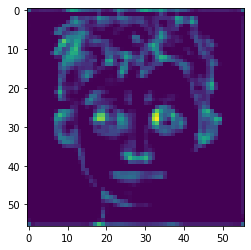

In [12]:
# control one feature map!!!!!! I was getting some super strange patch here...
display_image(train_FR_preds[21, ..., 0])

In [13]:
# filter predictions with train_lmk_idx
train_FR_lmk_preds = train_FR_preds[np.reshape(train_lmk_idx, -1)]
print("shape train_FR_lmk_preds", np.shape(train_FR_lmk_preds))
train_FER_lmk_preds = train_FER_preds[np.reshape(train_lmk_idx, -1)]
print("shape train_FER_lmk_preds", np.shape(train_FER_lmk_preds))

shape train_FR_lmk_preds (42, 56, 56, 68)
shape train_FER_lmk_preds (42, 56, 56, 18)


In [14]:
def filter_lmk_pos(lmk_pos, lmk_idx):
    filter_lmk_pos = []
    test_lmk_idx = []
    for i in range(np.shape(lmk_idx)[0]):
        for j in range(np.shape(lmk_idx)[1]):
            for k in range(np.shape(lmk_idx[i, j])[0]):
                test_lmk_idx.append(lmk_idx[i, j, k])
                filter_lmk_pos.append(lmk_pos[lmk_idx[i, j, k]][0])

    return np.array(filter_lmk_pos)

In [15]:
def construct_patterns(preds, pos, size, ratio=1):
    n_lmks = np.shape(pos)[1]
    n_patterns = np.shape(preds)[0]  # == n_images

    pad_x = int(size[0] / 2)
    pad_y = int(size[1] / 2)
    patterns = np.zeros((n_patterns, n_lmks, size[0], size[1], np.shape(preds)[-1]))

    for i in range(n_patterns):
        for j in range(n_lmks):
            x_pos = np.round(pos[i, j, 0] / ratio).astype(int)
            y_pos = np.round(pos[i, j, 1] / ratio).astype(int)
            x_patch = [x_pos - pad_x, x_pos + pad_x + 1]
            y_patch = [y_pos - pad_y, y_pos + pad_y + 1]
            patterns[i, j] = preds[i, y_patch[0]:y_patch[1], x_patch[0]:x_patch[1]]  # image x/y are shifted

    return patterns

In [16]:
# declare RBF parameters
posX = np.round(86 / 4).astype(int)
posY = np.round(114 / 4).astype(int)
filt_lmk_pos = filter_lmk_pos(lmk_pos, train_lmk_idx)
print("filt_lmk_pos (n_patterns, n_lmks, pos)", np.shape(filt_lmk_pos))
FR_patterns = construct_patterns(train_FR_lmk_preds, filt_lmk_pos[:, :3], (9, 9), ratio=224/56)  # issue is that FR_lmk_preds is not sorted as filt_lmk_pos???
# FER_patterns = construct_patterns(filt_lmk_pos[:, 3:], (3, 3), train_FER_lmk_preds, ratio=224/56)

print("(n_patterns, n_lmks, size, size, n_ft_map)")
print("shape FR_patterns", np.shape(FR_patterns))
# print("shape FER_patterns", np.shape(FER_patterns))

filt_lmk_pos (n_patterns, n_lmks, pos) (42, 13, 2)
(n_patterns, n_lmks, size, size, n_ft_map)
shape FR_patterns (42, 3, 9, 9, 68)


In [17]:
def compute_activity_map(ft_maps, patterns, sigma=1):
    """
    The function "convolve" with a RBF kernel all the patterns within the given feature maps

    small sigma => more selective
    large sigma => more robust

    :param ft_maps: (n_images, size, size, n_ft_maps)
    :param patterns: (n_patterns, n_lmks, k_size, k_size, n_ft_maps)
    :param sigma:
    :return: activity_map (n_images, n_patterns, n_lmks, size, size)
    """
    # declare activity map
    activity_map = np.zeros((np.shape(ft_maps)[0], np.shape(patterns)[0], np.shape(patterns)[1], np.shape(ft_maps)[1], np.shape(ft_maps)[2]))

    # compute padding
    pad_x = int(np.shape(patterns)[2] / 2)
    pad_y = int(np.shape(patterns)[3] / 2)

    # pad feature maps
    padded_ft_maps = np.zeros((np.shape(ft_maps)[0], np.shape(ft_maps)[1] + 2 * pad_x, np.shape(ft_maps)[2] + 2 * pad_y, np.shape(ft_maps)[3]))

    # compensate for padding of zeros
    if pad_x == 0 and pad_y== 0:
        padded_ft_maps = ft_maps
    elif pad_x == 0 and pad_y != 0:
        padded_ft_maps[:, :, pad_y:-pad_y, :] = ft_maps
    elif pad_x != 0 and pad_y == 0:
        padded_ft_maps[:, pad_x:-pad_x, :, :] = ft_maps
    else:
        padded_ft_maps[:, pad_x:-pad_x, pad_y:-pad_y, :] = ft_maps

    # expand pattern to match dimension to patch
    pattern = np.repeat(np.expand_dims(patterns, axis=0), np.shape(ft_maps)[0], axis=0)

    # compute for each position of the feature maps
    for i in range(pad_x, np.shape(ft_maps)[1] + pad_x):
        for j in range(pad_y, np.shape(ft_maps)[2] + pad_y):
            # get patch with matching size of the pattern
            x_pos = [i-pad_x, i+pad_x + 1]
            y_pos = [j-pad_y, j+pad_y + 1]
            patch = padded_ft_maps[:, x_pos[0]:x_pos[1], y_pos[0]:y_pos[1]]

            # expand patch and patterns to match dimensions (n_images, n_patterns, n_lmks, k_size, k_size, n_ft_maps)
            patch = np.repeat(np.expand_dims(patch, axis=1), len(patterns), axis=1)
            patch = np.repeat(np.expand_dims(patch, axis=2), np.shape(patterns)[1], axis=2)

            # compute diff between pattern and patch
            # (n_images, n_patterns, n_lmks, size, size, n_ft_map)
            diff = patch - pattern

            # compute activity
            flat_diff = np.reshape(diff, (np.shape(diff)[0], np.shape(diff)[1], np.shape(diff)[2], -1))  # flatten 3 last dimensions to apply norm on a single axis
            activity = np.exp(-np.linalg.norm(flat_diff, ord=2, axis=3) ** 2 / 2 / sigma ** 2)

            # save activity
            activity_map[..., i - pad_x, j - pad_y] = activity

    return activity_map

In [24]:
activity_maps = compute_activity_map(train_FR_preds[:5], FR_patterns, sigma=0.01)
print("shape activity_maps", np.shape(activity_maps))

shape activity_maps (5, 42, 3, 56, 56)


In [25]:
# max pool activities
max_pool_activities = np.amax(activity_maps, axis=1)
max_pool_activities_arg = np.argmax(activity_maps, axis=1)
print("shape max_pool_activity", np.shape(max_pool_activities))
print("shape max_pool_activities_arg", np.shape(max_pool_activities_arg))

shape max_pool_activity (5, 3, 56, 56)
shape max_pool_activities_arg (5, 3, 56, 56)


In [26]:
def display_FR_lmk(image, max_pool_activities, activities):
    print("shape activities", np.shape(activities))
    # display feature maps activity
    display_image(image, pre_processing='VGG19')
    display_images(max_pool_activities)
    for i in range(np.shape(activities)[1]):
        max_pool_over_maps = np.amax(activities[:, i], axis=(1, 2))
        pattern_idx = np.where(max_pool_over_maps >= .99)[0]

        unrav_idx = []
        for p in pattern_idx:
            unrav_idx.append(np.unravel_index(p, (6, 7)))

        print("lmk {} comes from pattern: {} - {}".format(i, pattern_idx, unrav_idx))

shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [6] - [(0, 6)]
lmk 1 comes from pattern: [6] - [(0, 6)]
lmk 2 comes from pattern: [6] - [(0, 6)]

shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [5] - [(0, 5)]
lmk 1 comes from pattern: [5] - [(0, 5)]
lmk 2 comes from pattern: [5] - [(0, 5)]

shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [9] - [(1, 2)]
lmk 1 comes from pattern: [9] - [(1, 2)]
lmk 2 comes from pattern: [9] - [(1, 2)]

shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [15] - [(2, 1)]
lmk 1 comes from pattern: [15] - [(2, 1)]
lmk 2 comes from pattern: [15] - [(2, 1)]

shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [] - []
lmk 1 comes from pattern: [] - []
lmk 2 comes from pattern: [] - []



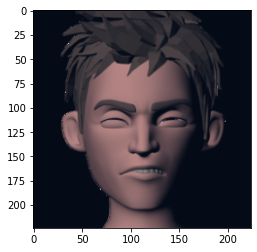

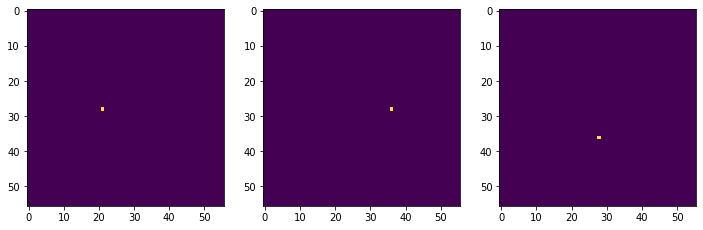

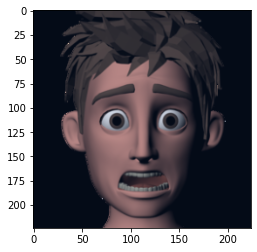

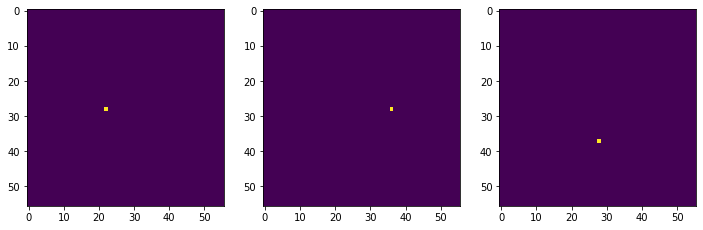

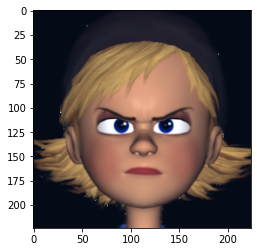

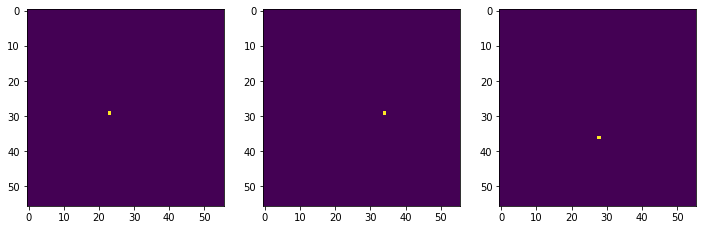

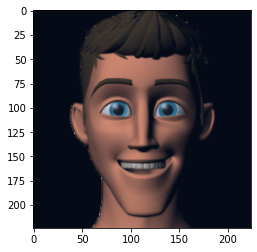

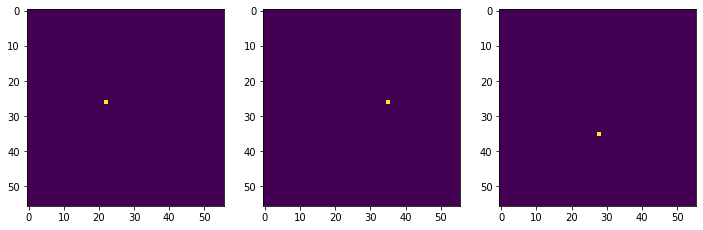

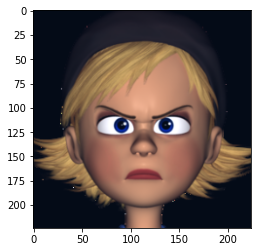

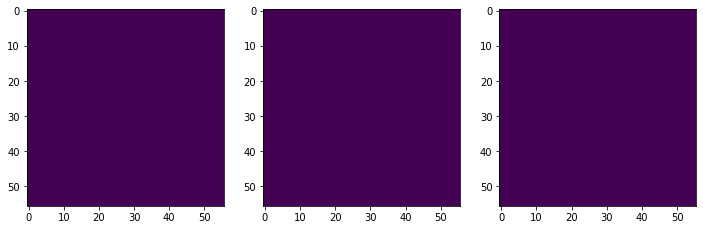

In [27]:
for i in range(len(activity_maps)):
    display_FR_lmk(train_data[0][i], max_pool_activities[i], activity_maps[i])
    print()

In [22]:
def find_patch_in_image(pos):
    # plot image that is responsible for activity
    resp_image_idx = train_lmk_idx[pos[0], pos[1]][0]
    print("resp_image_idx", resp_image_idx)
    pos = lmk_pos[resp_image_idx][0][1]
    print("position of pattern", pos)
    display_image(train_data[0][resp_image_idx][pos[1]-16:pos[1]+17, pos[0]-16:pos[0]+17], pre_processing='VGG19')

resp_image_idx 68
position of pattern [130, 94]


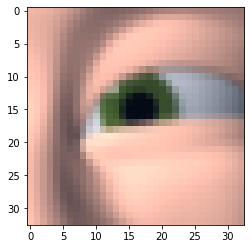

In [23]:
find_patch_in_image((3, 1))  # plot the patch responsible to train the pattern (3, 1)